# Laboratorio de Redes Neuronales aplicadas a series temporales - Parte 1: Preparación

### Contenidos
* Objetivo: descripción del problema a resolver.
* Creación del fichero de datos.
* Primeros intentos.
* Codificación de variables categóricas.
    * OneHotEncoder
* Normalización/Estandarización.
* División de datos en entrenamiento y prueba.
    * Validación cruzada.
    
## Objetivo:
Queremos predecir la tempertura en en siguiente instante, tomando como entrada el valor acutal y los anteriores.


## Cargar datos Meteorológicos de formato EXCEL a DataFrame

In [1]:
import pandas as pd

#### SI ESTÁS USANDO GOOGLE COLABORATORY
## Descomenta estas líneas
#from google.colab import files
#uploaded=files.upload()

#import io
#xls_file= pd.ExcelFile(io.BytesIO(uploaded['AEMET-2019.xlsx']))

## Si estás usando GOOGLE COLABORATORY 
## comenta la siguiente línea
xls_file=pd.ExcelFile ("AEMET-2019.xlsx")


xls_file.sheet_names
df = xls_file.parse ('Hoja1')
df.rename(columns = {'Fecha y hora oficial':'FechaHora', 'Velocidad del viento (km h)':'VelV',
                     'Dirección del viento':"DirV", 'Racha (km h)':'VelRacha', 'Dirección de racha':'DirRacha',
                     'Humedad (%)':'Humedad'}, inplace=True)
df.columns
# ordenar y limpiar, por si acaso...
df.sort_values(['FechaHora'], inplace=True)
df.dropna(inplace=True) # Quitamos algunos registros espúreos

FileNotFoundError: [Errno 2] No such file or directory: 'AEMET-2019.xlsx'

## Crear arrays de entrada y salida
Tiene que ser de acuerdo a la *historia* y al avance en la predicción buscada.

Creamos una vunción, pues vamos a hacer varios intentos.


In [ ]:
import numpy as np

def CreaArraysEntradaYSalida (Historia, Futuro, Datos):
    
    H=Historia
    F=Futuro
    a=Datos

    for i in range (0,H):
        Retardo_i=a[i:i-H]
        if i == 0:
            ArrayEntradas=np.array(Retardo_i)
        else:
            ArrayEntradas=np.append(ArrayEntradas, Retardo_i, axis=1)


    Salidas=a[H+F-1:]
    ArraySalidas=np.array (Salidas)

    return ArrayEntradas, ArraySalidas

 Comenzamos con un intento de predecir la temperatura de la siguiente
 hora (avance 1), utilizando los **solo datos de la temperatura** de hora acutal y las tres anteriores,
 es decir, una historia de 4 muestras.

 La lista de campos está en una celda anterior.
 El campo 7 (ínidce 6) es la temperatura.

In [ ]:
ArrayEntradas, ArraySalidas = CreaArraysEntradaYSalida (Historia=4, Futuro=1, Datos=df.iloc [:,[6]])

print (ArrayEntradas.shape)

import matplotlib.pyplot as pl

print ("ArrayEntradas\n", ArrayEntradas)
print ("ArraySalidas\n", ArraySalidas)
pl.plot (ArraySalidas)



# Predicción temperatura próxima hora.
## Intento 1
Usaremos el algoritmo de optimización SGD... a ver qué pasa.

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import History
import numpy as np 

history = History ()

print (ArrayEntradas.shape)

model = Sequential()
model.add(Dense(2, input_dim=4))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

sgd = SGD(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=sgd)

model.fit(ArrayEntradas, ArraySalidas, epochs=200, verbose=1, callbacks=[history])
print(model.predict(ArrayEntradas))

epochs=history.epoch
loss=history.history['loss']


pl.scatter (epochs, loss)



El intento no parece que haya ido bien... Sale un valor $loss$ que no se aproxima a cero, ¡y negativo!


## Intento 2
Tal vez cambiando a otro algoritmo... (RMSprop)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.callbacks import History
import numpy as np 

history = History ()

model = Sequential()
model.add(Dense(8, input_dim=4))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

OPTIMIZER=RMSprop(learning_rate=0.2)

model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER)

model.fit(ArrayEntradas, ArraySalidas, epochs=200, verbose=1, callbacks=[history])
print(model.predict(ArrayEntradas))

epochs=history.epoch
loss=history.history['loss']


pl.scatter (epochs, loss)

Tampoco ha funcionado...
**Pensemos**: los valores a predecir, ¿de qué rango son?


In [ ]:
df.Temp.describe ()

Resulta que la capa de salida es un elemento función de activación sigmoide, por lo que su rango de salidas es entre 0 y +1, difícilmente podremos llegar a tener rangos como el mostrado en la temperatura.
Debemos reescalar...

## Intento 3
Reescalar la salida entre 0 y 1.

**OJO**: los valores 0 y 1 no se alcanzan en la función sigmoide... Hay que pensárselo mejor, pero en nuestra búsqueda de algo que funcione, parece una buena primera idea.

### Primero reescalamos

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler ()
scaler.fit (ArraySalidas)
ArraySalidas_escaladas=scaler.transform (ArraySalidas)
print ("Original:\n", ArraySalidas, "\nEscalado:\n", ArraySalidas_escaladas)

### Creamos el modelo

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.callbacks import History
import numpy as np 

history = History ()

model = Sequential()
model.add(Dense(10, input_dim=4))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

OPTIMIZER=RMSprop(learning_rate=0.1)

model.compile(loss='mean_squared_error', optimizer=OPTIMIZER)

model.fit(ArrayEntradas, ArraySalidas_escaladas, epochs=200, verbose=1, callbacks=[history])
ArraySalidas_red=model.predict(ArrayEntradas)

epochs=history.epoch
loss=history.history['loss']


pl.scatter (epochs, loss)

¡Ahora sí que parece funcionar! Veamos cómo de bien lo hace:

In [ ]:
NumMuestras=240 # 24 muestras al día.
ArraySalidas_red_desescaladas=scaler.inverse_transform (ArraySalidas_red)
pl.plot (ArraySalidas[1:NumMuestras], color="g")
pl.plot (ArraySalidas_red_desescaladas[1:NumMuestras], color="r")
pl.show()

Parece que al fin funciona. Este será nuestro punto de partida. Para ello encapsulamos este código en una función llamada CreaModelo

### Función CreaModelo
Construimos una función que crea el modelo básico.
* Entradas: un vector de entradas, que puede se de tamaño variable, dependiendo del número de variables/atributos y de la historia que queramos usar.
* Salidas: en principio sólo vamos a predecir el valor de la temperatura.
* El número de elementos de proceso en la única capa oculta.

El resto de los parámetros (coeficiente de aprendizaje, tipos de activación, etc.) los dejamos por el momento fijados.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.callbacks import History
import numpy as np 


def CreaModelo (Entradas, Salidas, NumEPO):
    ArrayEntradas = Entradas
    ArraySalidas = Salidas
    nepo=NumEPO # elementos de proceso en la capa oculta

    DimEntrada=ArrayEntradas.shape[1]
            
    history = History ()

    model = Sequential()
    model.add(Dense(nepo, input_dim=DimEntrada))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    OPTIMIZER=RMSprop(learning_rate=0.1)

    model.compile(loss='mean_squared_error', optimizer=OPTIMIZER)

    model.fit(ArrayEntradas, ArraySalidas, epochs=200, verbose=0, callbacks=[history])
    ArraySalidas_red=model.predict(ArrayEntradas)

    epochs=history.epoch
    loss=history.history['loss']


    pl.scatter (epochs, loss)
    
    return ArraySalidas_red, model

In [ ]:
(ArraySalidas_red, modelo)=CreaModelo (ArrayEntradas, ArraySalidas_escaladas, 10)

## Aumentemos el número de entradas.
La temperatura dependerá también de la dirección del viento... (si sopla del Norte, probablemente bajará la temperatura) ¡Pero la dirección del viento DirV es una cadena de caracteres! ¿Cómo tratarla?

In [ ]:
df.iloc [0:10,[1,2,6]]

Sustituir la cadena de caractere que idenficia la Dirección del Viento por algún valor numérico (o combinaciones de valroes numéricos).
Usaremos el método LabelEncoder de sklearn

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Primero vemos lo que hay...

Etiquetas=df['DirV']
Etiquetas=list (dict.fromkeys (Etiquetas))
print ("Las etiquetas son: ", Etiquetas)

Etiquetador=LabelEncoder()
Etiquetador.fit(df.DirV)
DirV_enc=Etiquetador.transform(df.DirV)

NumValores=DirV_enc.shape[0]

NuevaColumna=DirV_enc.reshape(NumValores,1)
df_NuevaColumna=pd.DataFrame (NuevaColumna, columns=["DirV_codif"])


# Trabajamos con una copia local
df_nueva=df.iloc [:,[1,2,6]]

df2=df_nueva.join (df_NuevaColumna)


print (df2.iloc[0:10,:])

print ("Veamos cómo se ha codificado cada Dirección del Viento:")
print ("Valores: ", list (Etiquetador.classes_))
print ("Etiquetas: ", Etiquetador.transform (list (Etiquetador.classes_)))

Pero parece ser que la columna que representa la Dirección del Viento codificada con un número da más imortancia a la dirección Sur que a la Este (valor 8, frente a valor 1).
No basta sólo con codificar las etiquetas.

Busquemos una codificación que de igual importancia a cualquier dirección: la codificación OneHotEncode.

## OneHotEncode

In [ ]:
array_df2=np.array (df2.iloc[:,[3]])

ohe =OneHotEncoder (sparse=False)

ohe.fit (array_df2)

array_DirV_ohe=ohe.transform (array_df2.reshape (len (array_df2),1))

print ("Veamos el varray con el número de etiqueta para DirV\n", array_df2)
print ("Veamos el array con la codificación OneHotEncoding\n", array_DirV_ohe)

df_DirV_ohe=pd.DataFrame(array_DirV_ohe, columns=['DV_0', 'DV_1', 'DV_2', 'DV_3', 'DV_4', 'DV_5', 'DV_6', 'DV_7', 'DV_8'])

print ("Las nuevas columnas:\n", df_DirV_ohe)


#Creamos el nuevo conljunto de datos

df3 = pd.concat ([df.iloc[:,[1,6]], df_DirV_ohe], axis=1)

print ("Los nuevos datos:\n", df3)


In [ ]:
ArrayEntradas, ArraySalidas=CreaArraysEntradaYSalida (Historia=8, Futuro=1, Datos=df3)
scaler.fit (ArraySalidas[:,[2]])
ArraySalidas_escaladas=scaler.transform (ArraySalidas [:,[2]])

# De hecho, para nuesto problema de predicción de la temperatura,
# hay que realizar SIEMPRE el reescalado de la salida (columna de la temperatura)
# usando los datos de la columna correspondiente de ArraySalidas.

De hecho, para nuesto problema de predicción de la temperatura, hay que realizar SIEMPRE el reescalado de la salida (columna de la temperatura)  usando los datos de la columna correspondiente de ArraySalidas.

In [ ]:
# Creamos el modelo
(SalidasRed, Modelo)=CreaModelo (ArrayEntradas, ArraySalidas_escaladas, 10)

# Añadamos más variables de entrada.
Podemos pensar (¿?) que la presión admosférica también juega un papel importante en la predicción de la temperatura, por lo que deberíamos incluirla como entrada.

Pero, del mismo modo que vimos que era necesario reescalar el valor a predecir (la temperatura) a un intervalo que fuera reproducible por el elemento de proceso en la capa de salida (que usa una función sigmoidal, por lo que está entre 0 y 1), ahora debemos hacer algo semejante con la entrada Presión Atmosférica. 

In [ ]:
df.PresAtm.describe()

Como vemos, el rango de valores leídos está alrededor de los 920 hPa. Con un valor tan elevado, esa entrada inicialmente tendría mucha influencia en los resultados de la red.
Vamos a normalizarla, pero esta vez lo haremos a media 0 y desviación 1 ("estandarizaremos")
Y lo haremos también para la velocidad del viento y la temperatura; la Dirección del Viento, como hemos visto antes, usará OneHotEncode.

In [ ]:
from sklearn.preprocessing import StandardScaler

normstd=StandardScaler()

df4=df.iloc[:,[1,6,8]]
normstd.fit (df4)
df4_array=normstd.transform(df4)
df4_std=pd.DataFrame(df4_array, columns=['VelV_std', 'Temp_std', 'PresAtm_std'])
df4_std=df4_std.join(df_DirV_ohe)

df4_std




Ahora creamos los Arrays de Entradas y Array de Salida y creamos el modelo

In [ ]:
(ArrayEntradas, ArraySalidas)=CreaArraysEntradaYSalida (Historia=2,
                                                        Futuro=1,
                                                        Datos=df4_std)

# OJO: la temperatura (columna 2 --> Temp_std) está estandarizada, y la red tiene un elemento de 
# proceso tipo sigmoide en la salida. Habrá que extraer la columna estandarizada, des-estandarizarla
# y aplicar el escalado a 0-1

# Nos quedamos con las 3 primeras columnas de ArraySalida y las desnormalizamos
ArraySalidas_deseadasstd=normstd.inverse_transform (ArraySalidas [:,[0,1,2]])
scaler.fit (ArraySalidas_deseadasstd [:,[1]])
ArraySalidas_escaladas=scaler.transform (ArraySalidas_deseadasstd [:,[1]])

(SalidaRed, Modelo)=CreaModelo(Entradas=ArrayEntradas,
                               Salidas=ArraySalidas_escaladas,
                               NumEPO=8)

In [ ]:
# La temperatura es la columna 2 (índice 1) del total de 12 atributos.
# Nos quedamos sólo con los 3 primeros,
# que son los que hemos estandarizado

SalidasRedReal=scaler.inverse_transform (SalidaRed)
SalidasReales=normstd.inverse_transform (ArraySalidas[:,[0,1,2]])
pl.plot (SalidasRedReal[0:96], color="g")
pl.plot (SalidasReales[0:96,1], color="r")
pl.show ()

## Hacer experimentos en serio: dividir datos correctamente entre entrenamiento y prueba
Hasta ahora, por simplicidad, hemos usado los mismos datos para entrenar y para probar, Si la red "memoriza" los datos de entrada, el error será nulo, pero la capacidad de **generalizar** sobre entradas nuevas se ve disminuida. Este es el problema del **sobreentrenamiento** ($ovevfitting$).

¿Cómo se hace esa división? Depende...
Comencemos por un caso sencillo: tomemos la temperatura con el índice temporal (Temp y FechaHora) para ver cómo se dividen los datos.

In [ ]:
from sklearn.model_selection import train_test_split

ArrayEntradas, ArraySalidas = CreaArraysEntradaYSalida (Historia=2, Futuro=1, Datos=df.iloc[:,[0,6]])

ArrayEntradas_Train, ArrayEntradas_Test, ArraySalidas_Train, ArraySalidas_Test = train_test_split (ArrayEntradas,
                                                                                                   ArraySalidas,
                                                                                                   test_size=0.1)
print ("Entradas\n")
print ("Entrenamiento:\n", ArrayEntradas_Train[0:10,:])
print ("Prueba:\n", ArrayEntradas_Test[0:10,:])

print ("Salidas\n")
print ("Entrenamiento\n", ArraySalidas_Test [0:10,:])
print ("Prueba:\n", ArraySalidas_Test [0:10,:])

Vemos que los datos aparecen sin formar una secuencia (mezclados aleatoriamente), eso sí, cada vector de entrada contiene la secuencia correcta, pero la salida no es la correspondiente (en nusetro programa de ejemplo es debido a que hemos usado nuestra función "CrearArraysEntradaYSalida").

Si bien esa mezcla aleatoria (shuffle) es lo buscado en muchos casos (el los que las muestras de entrada son independientes undas de otras, es decir, el orden no importa), en nuetro caso el ORDEN SÍ QUE IMPORTA. Para evitar esto, podemos utilizar la bandera shuffle=False. Así:

In [ ]:
ArrayEntradas_Train, ArrayEntradas_Test, ArraySalidas_Train, ArraySalidas_Test = train_test_split (ArrayEntradas,
                                                                                                   ArraySalidas,
                                                                                                   test_size=0.1,
                                                                                                   shuffle=False)
print ("Entradas\n")
print ("Entrenamiento:\n", ArrayEntradas_Train[0:10,:])
print ("Prueba:\n", ArrayEntradas_Test[0:10,:])

print ("Salidas\n")
print ("Entrenamiento\n", ArraySalidas_Train [0:10,:])
print ("Prueba:\n", ArraySalidas_Test [0:10,:])

**¡OJO!** Si observas, el modelo creado utiliza para su entrenamiento los datos desde diciembre a abril, y prueba con los de la parte final de abril... Es decir, hemos creado el modelo para los meses de invierno y lo probamos con datos de primavera.

Hemos supuesto que el modelo es independiente del mes (o la estación) del año... y no lo es. Para hacerlo bien, deberíamos probar con unos pocos (quizás una semana, no más) más allá del último dato de entrenamiento. Pero bueno, eso es otra batalla que habrá que luchar más tarde.

Probemos el nuevo procedimiento.

In [ ]:
(ArrayEntradas, ArraySalidas)=CreaArraysEntradaYSalida (Historia=4,
                                                        Futuro=1,
                                                        Datos=df4_std)

# OJO: la temperatura (columna 2 --> Temp_std) está estandarizada, y la red tiene un elemento de 
# proceso tipo sigmoide en la salida. Habrá que extraer la columna estandarizada, des-estandarizarla
# y aplicar el escalado a 0-1

# Nos quedamos con las 3 primeras columnas de ArraySalida y las desnormalizamos
ArraySalidas_deseadasstd=normstd.inverse_transform (ArraySalidas [:,[0,1,2]])
scaler.fit (ArraySalidas_deseadasstd [:,[1]])
ArraySalidas_escaladas=scaler.transform (ArraySalidas_deseadasstd [:,[1]])

ArrayEntradas_Train, ArrayEntradas_Test, ArraySalidas_Train, ArraySalidas_Test = train_test_split (ArrayEntradas,
                                                                                                   ArraySalidas_escaladas,
                                                                                                   test_size=0.1,
                                                                                                   shuffle=False)


(SalidaRed, Modelo)=CreaModelo(Entradas=ArrayEntradas_Train,
                               Salidas=ArraySalidas_Train,
                               NumEPO=8)

In [ ]:
# Ahora probamos el modelo con los datos de test, que NO han sido usados hasta ahora.

SalidasRed_Test=Modelo.predict (ArrayEntradas_Test)

pl.plot (scaler.inverse_transform (SalidasRed_Test[0:480]), color="g", label="Salida red")
pl.plot (scaler.inverse_transform (ArraySalidas_Test [0:480]), color="r", label="Valor real")
pl.title ("Temperatura ºC")
pl.legend()
pl.show ()

### Validación cruzada de K particiones (k-fold cross validation)
La idea de separar los datos de entrenamiento y de prueba implica que los nunca se crearía un modelo para los datos que hemos separado para prueba, y quizás perderíamos algún caso relevante.

Por esa razón una técnica muy habitual es crear K particiones de los datos, y de forma rotativa, separar una de las particiones y entrenar con las otras, así tendríamos K modelos (en nuestro caso particular, todos los modelos son una red neuronal con la misma arquitectura, pero cada red/modelo ha entrenada con distintos datos), y habremos entrenado y probado con todos los datos disponibles, con lo que tendremos una mejor estimación de la bondad del modelo (definido por la arquitectura de la red), por ejemplo, calculando la media de los errores de lodelos.

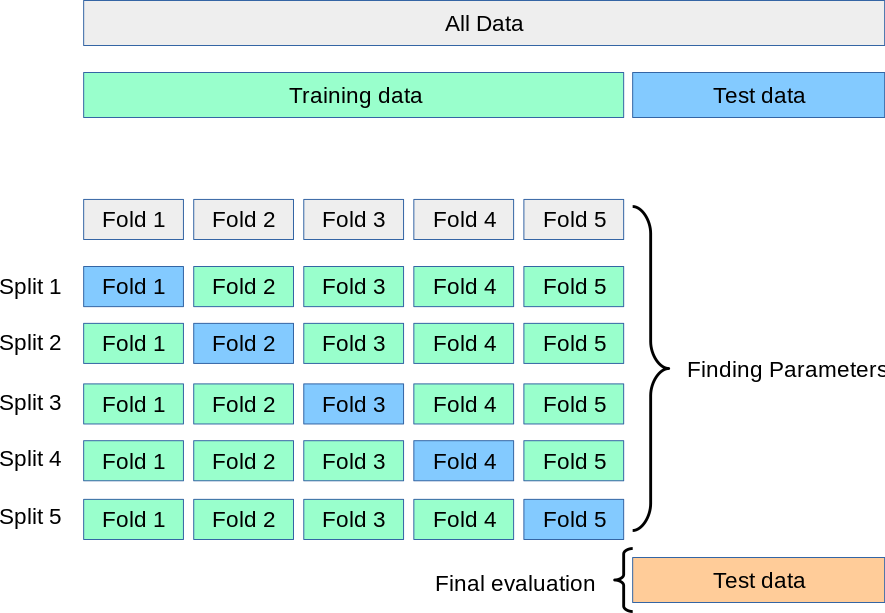

Haciendo esto con varios modelos, al final tendremos una idea más clara de qué modelo se comporta mejor sobre ese conjunto de datos.

Como habrás adivinado, seguimos haciendo trampa, pues elegimos el modelo para que trabaje bien con esos datos. Como fase final, hay que probar el modelo ganador de la etapa anterior con datos totalmente nuevos, que no han sido usados nunca.



Pero volvemos al problema que se indicó antes: en series temporales, el modelo debe ser sensible al momento al que se refieren los datos de entrenamiento, y además debe mantener su "continuidad temporal". Entonces, una mejor idea para hacer esto es la mostrada en la siguiente imagen:

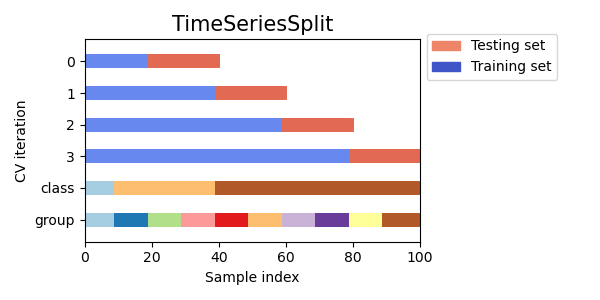

Como puedes ver, ahora el modelo usa datos contíguos en el tiempo para entrenar, y prueba siempre con los siguientes.

(Imágenes extraídas de https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Seguimos utilizando los datos de df4.
tss=TimeSeriesSplit (n_splits=3)

for Train, Test in tss.split (ArrayEntradas, ArraySalidas_escaladas):
    # Como el método split sólo devuelve la colección de índices (# de fila)
    # usamos np.take para obtener el vector de datos correspondiente
    kfoldSalidasStd = ArraySalidas_deseadasstd.take (Train)
    KfoldEntradas   = ArrayEntradas.take (Train)
    # A partir de aquí es igual...
    

## Consideraciones finales
La aproximación que hemos hecho a la predicción de la temperatura es lo primero que se nos ha ocurrido. Como es obvio, este problema requiere pensarlo mucho más si lo que queremos es un predictor competitivo y preciso.